## **Import Library**

In [2]:
!git clone https://github.com/ezaaputra/indonlu.git

import os

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

# NN
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from transformers import AutoTokenizer

import os
import nlpaug.augmenter.word as naw
import pandas as pd

fatal: destination path 'indonlu' already exists and is not an empty directory.


/opt/feza/aste_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Setting Device ke GPU**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## **Membuka File**

In [4]:
df = pd.read_excel("aspect_categorization/aspect_opini_expanded.xlsx")
df

,Teks,Label
0,Aplikasi ga guna,General Aspect
1,Aplikasi lemot parah,Functionality and Perfomance
2,Aplikasi ga guna,General Aspect
3,Aplikasi lemot parah,Functionality and Perfomance
4,Petugas kelurahan the best lah,Out of Aspect
...,...,...
8766,Tampilan Kaga dapat digunakan,User Interface
8767,Berbeda terlihat,User Interface
8768,Ini tampilan yang berbeda,User Interface
8769,tampilan terbatas,User Interface


In [5]:
texts = [str(text) for text in df['Teks'].tolist()]
label = df['Label'].tolist() #df['Aspect'].tolist()

In [6]:
df = pd.DataFrame({
    'Teks':texts,
    'Label':label
})

df

,Teks,Label
0,Aplikasi ga guna,General Aspect
1,Aplikasi lemot parah,Functionality and Perfomance
2,Aplikasi ga guna,General Aspect
3,Aplikasi lemot parah,Functionality and Perfomance
4,Petugas kelurahan the best lah,Out of Aspect
...,...,...
8766,Tampilan Kaga dapat digunakan,User Interface
8767,Berbeda terlihat,User Interface
8768,Ini tampilan yang berbeda,User Interface
8769,tampilan terbatas,User Interface


#### **Test**

In [62]:
# Set environment variable untuk menghindari paralelisme warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Inisialisasi augmenter menggunakan Back-Translation Indo <-> Eng
back_translation_aug = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-id-en',   # Indo to English
    to_model_name='Helsinki-NLP/opus-mt-en-id',     # English to Indo
)

# Filter label UI
df_ui = df[df['Label'] == 'User Interface'].copy()

# Lakukan augmentasi
augmented_texts = []
for text in df_ui['Teks']:
    for _ in range(1):  # jumlah augmentasi per teks
        new_text = back_translation_aug.augment(text)
        augmented_texts.append(new_text)

# Buat dataframe dari hasil augmentasi
df_aug = pd.DataFrame({
    'Teks': augmented_texts,
    'Label': ['User Interface'] * len(augmented_texts)
})

# Gabungkan dengan data asli
df_expanded = pd.concat([df, df_aug], ignore_index=True)

In [63]:
df = df_expanded.copy()
df.to_excel('aspect_categorization/aspect_opini_expanded.xlsx', index=False)

## **Inisisalisasi Function Informasi Model IndoBERT**

In [7]:
# common functions
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_params(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}: {:.2f}'.format(key, value))
    return ' '.join(string_list)

# Set random seed
set_seed(222112058)
print(set_seed)

<function set_seed at 0x7d92dd0c8b80>


## **Split Data**

In [8]:
train_set, val_set = train_test_split(df,test_size=0.3, stratify=df.Label, random_state=43)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.Label, random_state=43)

In [9]:
print(f"Train shape : {train_set.shape}")
print(f"Val shape : {val_set.shape} ")
print(f"Test shape : {test_set.shape} ")

Train shape : (6139, 2)
Val shape : (1763, 2) 
Test shape : (869, 2) 


In [10]:
# saya ingngin melihat distribusi aspek pada test_Set
print(test_set.Label.value_counts())

Label
Functionality and Perfomance    470
General Aspect                  149
User Experince                  128
Out of Aspect                    60
Support and Updates              49
Security                          7
User Interface                    6
Name: count, dtype: int64


In [11]:
train_set.to_csv('aspect_categorization/train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('aspect_categorization/val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('aspect_categorization/test_set.tsv', sep='\t', header=None, index=False)

## **Class Untuk Import Data**

In [12]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
#####
# Document Sentiment Prosa
#####
class DocumentSentimentDataset(Dataset):

    LABEL2INDEX = {'User Interface': 0, 'User Experince': 1, 'Functionality and Perfomance': 2, 'Security': 3, 'Support and Updates':4, 'General Aspect':5, 'Out of Aspect':6} # Correct label mapping
    INDEX2LABEL = {0: 'User Interface', 1: 'User Experince', 2: 'Functionality and Perfomance', 3: 'Security', 4: 'Support and Updates', 5: 'General Aspect', 6: 'Out of Aspect'}
    NUM_LABELS = 7 

    def load_dataset(self, path):
        df = pd.read_csv(path, sep='\t', header=None)
        df.columns = ['text','sentiment']
        df['sentiment'] = df['sentiment'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df

    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        data = self.data.loc[index,:]
        text, sentiment = data['text'], data['sentiment']
        subwords = self.tokenizer.encode(text, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(sentiment), data['text']

    def __len__(self):
        return len(self.data)

class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64) # Ensures correct label shape

        seq_list = []
        for i, (subwords, sentiment, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            sentiment_batch[i,0] = sentiment

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, sentiment_batch, seq_list

## **Import Model IndoBERT-base-p2**

In [13]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p2')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', config=config)

# Struktur model
print(model)

# Jumlah parameter
print(count_params(model))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## **Ilustrasi Proses Tokenisasi INDOBERT (Subword)**

In [14]:
teks = df.Teks.values
tokenized_texts = tokenizer.tokenize(teks[5000])

input_ids = []

for sent in teks:
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens = True
    )
    input_ids.append(encoded_sent)

print("Original: ", teks[5000])
print("Tokenized: ", tokenized_texts)
print("Token IDs: ", input_ids[5000])

Original:  aplikasi gak conent sistem
Tokenized:  ['aplikasi', 'gak', 'con', '##ent', 'sistem']
Token IDs:  [2, 1339, 1489, 2383, 153, 737, 3]


In [15]:
train_dataset_path = "aspect_categorization/train_set.tsv"
valid_dataset_path = "aspect_categorization/val_set.tsv"
test_dataset_path = "aspect_categorization/test_set.tsv"

## **DataLoader Untuk Persiapan Fine-Tuning**

In [16]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=1, num_workers=0, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=1, num_workers=0, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=1, num_workers=0, shuffle=False)

## **Mapping Label Sentimen**

In [17]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'User Interface': 0, 'User Experince': 1, 'Functionality and Perfomance': 2, 'Security': 3, 'Support and Updates': 4, 'General Aspect': 5, 'Out of Aspect': 6}
{0: 'User Interface', 1: 'User Experince', 2: 'Functionality and Perfomance', 3: 'Security', 4: 'Support and Updates', 5: 'General Aspect', 6: 'Out of Aspect'}


In [18]:
optimizer = optim.Adam(model.parameters(), lr = 2e-5, weight_decay=0.01)
model = model.cuda()

## **Mulai Fine-Tuning**

In [20]:
train_loss_lists = []
train_acc_lists = []
eval_loss_lists = []
eval_acc_lists = []

# Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    train_acc_lists.append(metrics['ACC'])
    current_train_loss = round(total_train_loss/(i+1), 4)
    train_loss_lists.append(current_train_loss)

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    eval_acc_lists.append(metrics['ACC'])
    current_eval_loss = round(total_loss/(i+1), 4)
    eval_loss_lists.append(current_eval_loss)

  0%|          | 0/6139 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.6563 LR:0.00002000: 100%|██████████| 6139/6139 [02:14<00:00, 45.74it/s]


(Epoch 1) TRAIN LOSS:0.6563 ACC: 0.77 F1: 0.57 REC: 0.54 PRE: 0.68 LR:0.00002000


VALID LOSS:0.5986 ACC: 0.82 F1: 0.69 REC: 0.73 PRE: 0.70: 100%|██████████| 1763/1763 [00:18<00:00, 94.63it/s]


(Epoch 1) VALID LOSS:0.5986 ACC: 0.82 F1: 0.69 REC: 0.73 PRE: 0.70


(Epoch 2) TRAIN LOSS:0.4545 LR:0.00002000: 100%|██████████| 6139/6139 [02:14<00:00, 45.78it/s]


(Epoch 2) TRAIN LOSS:0.4545 ACC: 0.84 F1: 0.70 REC: 0.67 PRE: 0.79 LR:0.00002000


VALID LOSS:0.4658 ACC: 0.83 F1: 0.70 REC: 0.66 PRE: 0.79: 100%|██████████| 1763/1763 [00:18<00:00, 94.33it/s]


(Epoch 2) VALID LOSS:0.4658 ACC: 0.83 F1: 0.70 REC: 0.66 PRE: 0.79


(Epoch 3) TRAIN LOSS:0.3881 LR:0.00002000: 100%|██████████| 6139/6139 [02:14<00:00, 45.77it/s]


(Epoch 3) TRAIN LOSS:0.3881 ACC: 0.87 F1: 0.74 REC: 0.70 PRE: 0.82 LR:0.00002000


VALID LOSS:0.4374 ACC: 0.86 F1: 0.73 REC: 0.69 PRE: 0.86: 100%|██████████| 1763/1763 [00:18<00:00, 93.86it/s]


(Epoch 3) VALID LOSS:0.4374 ACC: 0.86 F1: 0.73 REC: 0.69 PRE: 0.86


(Epoch 4) TRAIN LOSS:0.3391 LR:0.00002000: 100%|██████████| 6139/6139 [02:14<00:00, 45.68it/s]


(Epoch 4) TRAIN LOSS:0.3391 ACC: 0.89 F1: 0.80 REC: 0.76 PRE: 0.85 LR:0.00002000


VALID LOSS:0.4163 ACC: 0.86 F1: 0.79 REC: 0.76 PRE: 0.86: 100%|██████████| 1763/1763 [00:18<00:00, 94.38it/s]


(Epoch 4) VALID LOSS:0.4163 ACC: 0.86 F1: 0.79 REC: 0.76 PRE: 0.86


(Epoch 5) TRAIN LOSS:0.3095 LR:0.00002000: 100%|██████████| 6139/6139 [02:14<00:00, 45.68it/s]


(Epoch 5) TRAIN LOSS:0.3095 ACC: 0.90 F1: 0.85 REC: 0.83 PRE: 0.88 LR:0.00002000


VALID LOSS:0.3970 ACC: 0.88 F1: 0.83 REC: 0.82 PRE: 0.84: 100%|██████████| 1763/1763 [00:18<00:00, 93.68it/s]


(Epoch 5) VALID LOSS:0.3970 ACC: 0.88 F1: 0.83 REC: 0.82 PRE: 0.84


## **Plot Loss dan Accuracy**

Text(0.5, 0, 'Epoch')

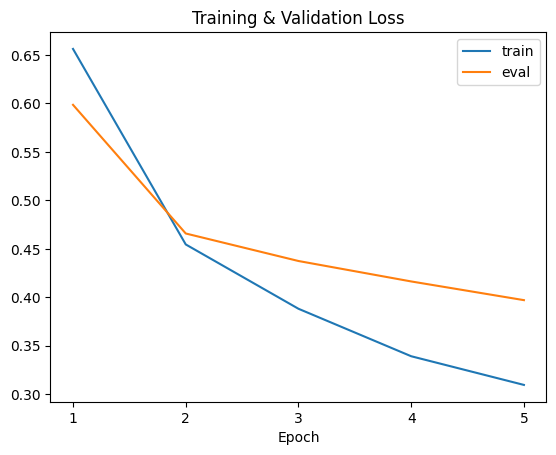

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(train_loss_lists, label='train')
plt.plot(eval_loss_lists, label='eval')
plt.title('Training & Validation Loss')
plt.xticks(np.arange(len(train_loss_lists)), np.arange(1, len(eval_loss_lists)+1))
plt.legend()
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

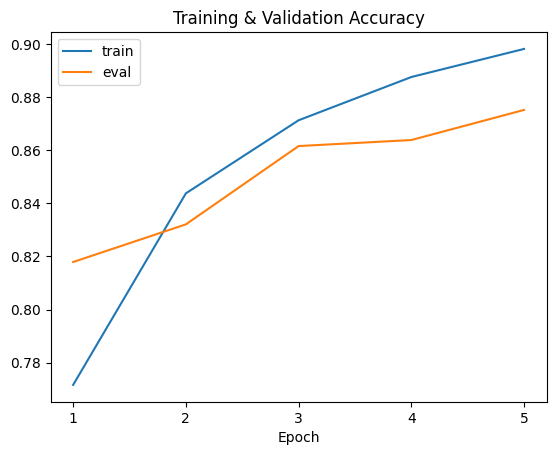

In [22]:
plt.plot(train_acc_lists, label='train')
plt.plot(eval_acc_lists, label='eval')
plt.title('Training & Validation Accuracy')
plt.xticks(np.arange(len(train_acc_lists)), np.arange(1, len(eval_acc_lists)+1))
plt.legend()
plt.xlabel('Epoch')

## **Evaluate pada Data Test**

In [23]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_label

# Save prediction

100%|██████████| 869/869 [00:02<00:00, 409.77it/s]


In [24]:
metrics = document_sentiment_metrics_fn(list_hyp, list_label)
metrics

{'ACC': 0.8665132336018412,
 'F1': 0.821273509593075,
 'REC': 0.8056515096629419,
 'PRE': 0.8457822718627923}

In [30]:
## save model
torch.save(model.state_dict(), 'model_klasifikasi_aspek/model_aspect_categorization.pt')

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_label, list_hyp)

cm

array([[442,  11,   3,   1,   2,  11,   0],
       [ 13, 109,   3,   0,   0,  24,   0],
       [  1,   1,  47,   0,   0,  11,   0],
       [  1,   1,   0,   5,   0,   0,   0],
       [  1,   1,   6,   0,  40,   1,   0],
       [  6,   4,  12,   0,   1, 105,   0],
       [  0,   1,   0,   0,   0,   0,   5]])

In [ ]:
report = classification_report(list_label, list_hyp, digits=2, zero_division=0)

print(report)

                              precision    recall  f1-score   support

Functionality and Perfomance       0.95      0.94      0.95       470
              General Aspect       0.85      0.73      0.79       149
               Out of Aspect       0.66      0.78      0.72        60
                    Security       0.83      0.71      0.77         7
         Support and Updates       0.93      0.82      0.87        49
              User Experince       0.69      0.82      0.75       128
              User Interface       1.00      0.83      0.91         6

                    accuracy                           0.87       869
                   macro avg       0.85      0.81      0.82       869
                weighted avg       0.87      0.87      0.87       869



In [29]:
# Model ke mode evaluasi
model.eval()
torch.set_grad_enabled(False)

# Kalimat yang ingin diuji
new_text = "aplikasi ndak bisa kelola aplikasi"

# Tokenisasi kalimat
tokenized_input = tokenizer(new_text, padding=True, truncation=True, return_tensors="pt")

# Pindahkan input ke device (GPU jika tersedia)
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenized_input = {key: value.to(device) for key, value in tokenized_input.items()}
model.to(device)

# Forward pass untuk mendapatkan prediksi
with torch.no_grad():
    output = model(**tokenized_input)
    predictions = torch.argmax(output.logits, dim=1)  # Ambil label dengan probabilitas tertinggi

# Mapping hasil prediksi ke label kelas
predicted_label = i2w[predictions.item()]

# Cetak hasil prediksi
print(f"Teks: {new_text}")
print(f"Prediksi Label: {predicted_label}")

Teks: aplikasi ndak bisa kelola aplikasi
Prediksi Label: Functionality and Perfomance
